# Colab データインストール

In [0]:
# 以下を実行すると、認証情報を取得するための許可を求められるので、許可してトークンを発行し、テキストボックスに貼り付ける。
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [2]:
# Colabにおいてデータを読みこむ。グーグルドライブをマウントします。その為に必要なパッケージを取得しておく。
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


gpg: keybox '/tmp/tmplwdgpq08/pubring.gpg' created
gpg: /tmp/tmplwdgpq08/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [3]:
# 以下実行により、今度は google-drive-ocamlfuse によるアクセスの許可を聞かれる。これも許可する。
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [4]:
# 今回は指定したフォルダのみマウントする
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1FwGdPnKlcYYRe1mZGE5Ci-PWlIY8k5J7/" config
# 上記が正常に終われば、ようやくマウントが可能となる。
!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

Clearing cache...done
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
8_10-11  8_5-6			     Santander_Value_Prediction_Challenge
8_12-13  8_7-8			     test.ipynb
8_14	 compare-deeplibs.ipynb      week3-EDA
8_15-16  dataマウントテンプレ.ipynb  week4
8_18-19  dataset
8_3-4	 Kaggle_0


In [1]:
# これ以降はターミナルと同様にディレクトリを扱える
ls

adc.json  config  datalab@  drive/  sample_data/


In [2]:
cd drive/dataset/Recruit/

/content/drive/dataset/Recruit


In [3]:
ls

air_reserve.csv     hpg_reserve.csv        submission (7167fec5).csv
air_store_info.csv  hpg_store_info.csv     submission.csv
air_visit_data.csv  sample_submission.csv  test_df.csv
date_info.csv       store_id_relation.csv  train_df.csv


# Recruit Restaurant Visitor Forecasting

### Setting Imports

In [24]:
!pip install lightgbm

    100% |████████████████████████████████| 737kB 7.2MB/s 


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn import model_selection, ensemble, neighbors
from sklearn.linear_model import LogisticRegression

from subprocess import check_output
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import preprocessing

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# pd.DataFrame型のprint用 (例) display(df.head(), df.tail())
from IPython.display import display

# pandasのデータの表示
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_row', 300)

### Read in Data 

In [0]:
data = {
    'tra': pd.read_csv('air_visit_data.csv'),
    'as': pd.read_csv('air_store_info.csv'),
    'hs': pd.read_csv('hpg_store_info.csv'),
    'ar': pd.read_csv('air_reserve.csv'),
    'hr': pd.read_csv('hpg_reserve.csv'),
    'id': pd.read_csv('store_id_relation.csv'),
    'tes': pd.read_csv('sample_submission.csv'),
    'hol': pd.read_csv('date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [37]:
display(data['ar'])
display(data['hr'])
display(data['tes'])

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
...,...,...,...,...
92377,air_3cad29d1a23209d2,2017-05-31 21:00:00,2017-04-22 10:00:00,3


,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
...,...,...,...,...
2000319,hpg_0b70de808b55ad1e,2017-05-31 23:00:00,2017-04-21 13:00:00,6


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
...,...,...
32018,air_fff68b929994bfbd_2017-05-31,0


In [38]:
# hpgのidはairと統一
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])
data['hr'].drop('hpg_store_id',  axis=1, inplace=True)
data['ar'] = data['ar'].append(data['hr'])

# tesのidとdateは分割
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
test_id = data['tes']['id']
data['tes'].drop('id', axis=1, inplace=True)
print ('Data loaded - number visits: ' + str(data['tra'].shape[0]))

Data loaded - number visits: 252108


In [39]:
display(data['ar'])
display(data['hr'])
display(data['tes'])

,air_store_id,reserve_datetime,reserve_visitors,visit_datetime
0,air_877f79706adbfb06,2016-01-01 16:00:00,1,2016-01-01 19:00:00
...,...,...,...,...
28182,air_84f6876ff7e83ae7,2017-04-10 22:00:00,5,2017-04-28 18:00:00


,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
...,...,...,...,...
28182,2017-04-28 18:00:00,2017-04-10 22:00:00,5,air_84f6876ff7e83ae7


,visitors,air_store_id,visit_date
0,0,air_00a91d42b08b08d9,2017-04-23
...,...,...,...
32018,0,air_fff68b929994bfbd,2017-05-31


In [0]:
# Create single data set with all relevant base data:
# 曜日の付与
data['tra']['visit_datetime'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow']     = data['tra']['visit_datetime'].dt.dayofweek
data['ar']['res_visit_datetime'] = pd.to_datetime(data['ar']['visit_datetime'])
data['ar']['reserve_datetime']   = pd.to_datetime(data['ar']['reserve_datetime'])
data['ar']['visit_date']         = data['ar']['res_visit_datetime'].dt.date

# 予約日と来店日の差
data['ar']['reserve_diff'] = data['ar'].apply(lambda r: (r['res_visit_datetime']
                                                         - r['reserve_datetime']).days, 
                                        axis=1)
data['ar'].drop('visit_datetime',  axis=1, inplace=True)
data['ar'].drop('reserve_datetime',  axis=1, inplace=True)
data['ar'].drop('res_visit_datetime',  axis=1, inplace=True)
avg_reserv = data['ar'].groupby(['air_store_id','visit_date'], 
                                as_index=False).mean().reset_index()
data['ar'] = data['ar'].groupby(['air_store_id','visit_date'], 
                                as_index=False).sum().reset_index()
data['ar'] = data['ar'].drop(['reserve_diff'],axis=1)
data['ar'] = data['ar'].drop(['index'],axis=1)
data['ar']['reserve_diff'] = avg_reserv['reserve_diff']  
data['ar']['visit_date'] = data['ar']['visit_date'].astype(str)    

# 曜日の付与
data['tes']['visit_datetime'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow']     = data['tes']['visit_datetime'].dt.dayofweek

In [41]:
display(data['tra'])
display(data['ar'])
display(data['tes'])

,air_store_id,visit_date,visitors,visit_datetime,dow
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,2
...,...,...,...,...,...
252107,air_24e8414b9b07decb,2017-04-22,5,2017-04-22,5


,air_store_id,visit_date,reserve_visitors,reserve_diff
0,air_00a91d42b08b08d9,2016-01-14,2,3.0
...,...,...,...,...
42192,air_fee8dcf4d619598e,2017-01-09,5,8.0


,visitors,air_store_id,visit_date,visit_datetime,dow
0,0,air_00a91d42b08b08d9,2017-04-23,2017-04-23,6
...,...,...,...,...,...
32018,0,air_fff68b929994bfbd,2017-05-31,2017-05-31,2


In [42]:
# trainデータとして、お店のジャンル、エリア、緯度経度、　曜日(ダブり)、祝日を付与
prep_df = pd.merge(data['tra'], data['ar'],  how='left', on=['air_store_id', 'visit_date'])
prep_df = pd.merge(prep_df,     data['as'],  how='inner', on='air_store_id')
prep_df = pd.merge(prep_df,     data['hol'], how='left',  on='visit_date')
prep_df = prep_df[prep_df['visit_date'] >= '2016-06-29']
print ('Data merged - number visits in train: ' + str(prep_df.shape[0]))

# testデータとして、お店のジャンル、エリア、緯度経度、　曜日(ダブり)、祝日を付与
predict_data = pd.merge(data['tes'],  data['ar'],   how='left', on=['air_store_id', 'visit_date'])
predict_data = pd.merge(predict_data, data['as'],   how='inner', on='air_store_id')
predict_data = pd.merge(predict_data, data['hol'],  how='left', on='visit_date')
print ('Data merged - number visits in test: ' + str(predict_data.shape[0]))


Data merged - number visits in train: 204989
Data merged - number visits in test: 32019


In [43]:
display(prep_df)
display(predict_data)

,air_store_id,visit_date,visitors,visit_datetime,dow,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
138,air_ba937bf13d40fb24,2016-06-29,33,2016-06-29,2,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252107,air_24e8414b9b07decb,2017-04-22,5,2017-04-22,5,NaN,NaN,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,Saturday,0


,visitors,air_store_id,visit_date,visit_datetime,dow,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg
0,0,air_00a91d42b08b08d9,2017-04-23,2017-04-23,6,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Sunday,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32018,0,air_fff68b929994bfbd,2017-05-31,2017-05-31,2,NaN,NaN,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,Wednesday,0


In [0]:
# min_visitors	mean_visitors	median_visitors	max_visitors	count_observations の付与
# 店舗の曜日ごとの、来店客の、最低、最高、平均、標準、出現回数　をカラム化
# 予測日の訪問者の数は、前年の同じ曜日の平均訪問者数に等しくなりやすいため有効(仮説)

tmp = data['tra'].groupby(['air_store_id', 'dow'], as_index=False)['visitors'].min().rename(
    columns={'visitors': 'dow_min_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(['air_store_id', 'dow'], as_index=False)['visitors'].mean().rename(
    columns={'visitors': 'dow_mean_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(['air_store_id', 'dow'], as_index=False)['visitors'].median().rename(
    columns={'visitors': 'dow_median_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(['air_store_id', 'dow'], as_index=False)['visitors'].max().rename(
    columns={'visitors': 'dow_max_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = data['tra'].groupby(['air_store_id', 'dow'], as_index=False)['visitors'].count().rename(
    columns={'visitors': 'dow_count_observations'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'dow'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'dow'])

prep_df.drop('dow',  axis=1, inplace=True)
predict_data.drop('dow',  axis=1, inplace=True)


In [45]:
display(prep_df)
display(predict_data)

,air_store_id,visit_date,visitors,visit_datetime,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations
0,air_ba937bf13d40fb24,2016-06-29,33,2016-06-29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0,7,23.843750,25.0,57,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204988,air_24e8414b9b07decb,2017-04-22,5,2017-04-22,NaN,NaN,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,Saturday,0,2,5.289474,6.0,8,38


,visitors,air_store_id,visit_date,visit_datetime,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations
0,0,air_00a91d42b08b08d9,2017-04-23,2017-04-23,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Sunday,0,2.0,2.000000,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32018,0,air_fff68b929994bfbd,2017-05-31,2017-05-31,NaN,NaN,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,Wednesday,0,1.0,4.634146,4.0,12.0,41.0


In [0]:
# 曜日と同様のことを祝日に対して適応

tmp_2 = pd.merge(data['tra'],  data['hol'], how='left',  on='visit_date')

tmp = tmp_2.groupby(['air_store_id', 'holiday_flg'], as_index=False)['visitors'].min().rename(
    columns={'visitors': 'hol_min_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'holiday_flg'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'holiday_flg'])
tmp = tmp_2.groupby(['air_store_id', 'holiday_flg'], as_index=False)['visitors'].mean().rename(
    columns={'visitors': 'hol_mean_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'holiday_flg'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'holiday_flg'])
tmp = tmp_2.groupby(['air_store_id', 'holiday_flg'], as_index=False)['visitors'].median().rename(
    columns={'visitors': 'hol_median_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'holiday_flg'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'holiday_flg'])
tmp = tmp_2.groupby(['air_store_id', 'holiday_flg'], as_index=False)['visitors'].max().rename(
    columns={'visitors': 'hol_max_visitors'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'holiday_flg'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'holiday_flg'])
tmp = tmp_2.groupby(['air_store_id', 'holiday_flg'], as_index=False)['visitors'].count().rename(
    columns={'visitors': 'hol_count_observations'})
prep_df = pd.merge(prep_df, tmp, how='left', on=['air_store_id', 'holiday_flg'])
predict_data = pd.merge(predict_data, tmp, how='left', on=['air_store_id', 'holiday_flg'])

In [47]:
display(prep_df)
display(predict_data)

,air_store_id,visit_date,visitors,visit_datetime,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations,hol_min_visitors,hol_mean_visitors,hol_median_visitors,hol_max_visitors,hol_count_observations
0,air_ba937bf13d40fb24,2016-06-29,33,2016-06-29,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0,7,23.843750,25.0,57,64,1,22.931937,22.0,61,382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204988,air_24e8414b9b07decb,2017-04-22,5,2017-04-22,NaN,NaN,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,Saturday,0,2,5.289474,6.0,8,38,1,5.602679,6.0,25,224


,visitors,air_store_id,visit_date,visit_datetime,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations,hol_min_visitors,hol_mean_visitors,hol_median_visitors,hol_max_visitors,hol_count_observations
0,0,air_00a91d42b08b08d9,2017-04-23,2017-04-23,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Sunday,0,2.0,2.000000,2.0,2.0,1.0,1.0,26.103896,26.0,99.0,231.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32018,0,air_fff68b929994bfbd,2017-05-31,2017-05-31,NaN,NaN,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,Wednesday,0,1.0,4.634146,4.0,12.0,41.0,1.0,5.093385,5.0,18.0,257.0


In [0]:
# Encode fields:
# 年はデータとして落とし、月、日をそれぞれカラム化

prep_df['month'] = prep_df['visit_datetime'].dt.month
prep_df['day']   = prep_df['visit_datetime'].dt.day
#prep_df['woy']   = prep_df['visit_datetime'].dt.weekofyear
prep_df.drop('visit_datetime',      axis=1, inplace=True)   
predict_data['month'] = predict_data['visit_datetime'].dt.month
predict_data['day']   = predict_data['visit_datetime'].dt.day
#predict_data['woy']   = predict_data['visit_datetime'].dt.weekofyear
predict_data.drop('visit_datetime', axis=1, inplace=True)

In [49]:
display(prep_df)
display(predict_data)

,air_store_id,visit_date,visitors,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations,hol_min_visitors,hol_mean_visitors,hol_median_visitors,hol_max_visitors,hol_count_observations,month,day
0,air_ba937bf13d40fb24,2016-06-29,33,NaN,NaN,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0,7,23.843750,25.0,57,64,1,22.931937,22.0,61,382,6,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204988,air_24e8414b9b07decb,2017-04-22,5,NaN,NaN,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,Saturday,0,2,5.289474,6.0,8,38,1,5.602679,6.0,25,224,4,22


,visitors,air_store_id,visit_date,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations,hol_min_visitors,hol_mean_visitors,hol_median_visitors,hol_max_visitors,hol_count_observations,month,day
0,0,air_00a91d42b08b08d9,2017-04-23,NaN,NaN,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Sunday,0,2.0,2.000000,2.0,2.0,1.0,1.0,26.103896,26.0,99.0,231.0,4,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32018,0,air_fff68b929994bfbd,2017-05-31,NaN,NaN,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,Wednesday,0,1.0,4.634146,4.0,12.0,41.0,1.0,5.093385,5.0,18.0,257.0,5,31


In [0]:
# 欠損値を-1という情報で埋める
# 理由は、欠損は欠損値という情報のままで利用させるための案
prep_df.fillna(-1, inplace=True)
predict_data.fillna(-1, inplace=True)

In [53]:
display(prep_df)
display(predict_data)

,air_store_id,visit_date,visitors,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations,hol_min_visitors,hol_mean_visitors,hol_median_visitors,hol_max_visitors,hol_count_observations,month,day
0,air_ba937bf13d40fb24,2016-06-29,33,-1.0,-1.0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,Wednesday,0,7,23.843750,25.0,57,64,1,22.931937,22.0,61,382,6,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204988,air_24e8414b9b07decb,2017-04-22,5,-1.0,-1.0,Other,Tōkyō-to Shibuya-ku Higashi,35.653217,139.711036,Saturday,0,2,5.289474,6.0,8,38,1,5.602679,6.0,25,224,4,22


,visitors,air_store_id,visit_date,reserve_visitors,reserve_diff,air_genre_name,air_area_name,latitude,longitude,day_of_week,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations,hol_min_visitors,hol_mean_visitors,hol_median_visitors,hol_max_visitors,hol_count_observations,month,day
0,0,air_00a91d42b08b08d9,2017-04-23,-1.0,-1.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,Sunday,0,2.0,2.000000,2.0,2.0,1.0,1.0,26.103896,26.0,99.0,231.0,4,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32018,0,air_fff68b929994bfbd,2017-05-31,-1.0,-1.0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,Wednesday,0,1.0,4.634146,4.0,12.0,41.0,1.0,5.093385,5.0,18.0,257.0,5,31


In [0]:
# Encode labels of categorical columns:
# 曜日、ジャンル、エリアに対してダミー変数化
cat_features = [col for col in ['air_genre_name', 'air_area_name', 'day_of_week']]
for column in cat_features:
    temp_prep = pd.get_dummies(pd.Series(prep_df[column]))
    prep_df = pd.concat([prep_df,temp_prep],axis=1)
    prep_df = prep_df.drop([column],axis=1)
    temp_predict = pd.get_dummies(pd.Series(predict_data[column]))
    predict_data = pd.concat([predict_data,temp_predict],axis=1)
    predict_data = predict_data.drop([column],axis=1)
    for missing_col in temp_prep:     # Make sure the columns of train and test are identical
        if missing_col not in predict_data.columns:
            predict_data[missing_col] = 0
    for missing_col in temp_predict:     # Make sure the columns of train and test are identical
        if missing_col not in prep_df.columns:
            prep_df[missing_col] = 0        

In [55]:
display(prep_df)
display(predict_data)

,air_store_id,visit_date,visitors,reserve_visitors,reserve_diff,latitude,longitude,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations,hol_min_visitors,hol_mean_visitors,hol_median_visitors,hol_max_visitors,hol_count_observations,month,day,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food,Fukuoka-ken Fukuoka-shi Daimyō,Fukuoka-ken Fukuoka-shi Hakata Ekimae,Fukuoka-ken Fukuoka-shi Imaizumi,Fukuoka-ken Fukuoka-shi Momochi,Fukuoka-ken Fukuoka-shi Shiobaru,Fukuoka-ken Fukuoka-shi Takatori,Fukuoka-ken Fukuoka-shi Tenjin,Fukuoka-ken Fukuoka-shi Torikai,Fukuoka-ken Itoshima-shi Maebarunishi,Fukuoka-ken Kitakyūshū-shi Konyamachi,Fukuoka-ken Kitakyūshū-shi None,Fukuoka-ken Kitakyūshū-shi Ōtemachi,Fukuoka-ken Kurume-shi Jōnanmachi,Fukuoka-ken Yame-shi Motomachi,Hiroshima-ken Fukuyama-shi Higashisakuramachi,Hiroshima-ken Hiroshima-shi Kokutaijimachi,Hiroshima-ken Hiroshima-shi Nagarekawachō,Hokkaidō Abashiri-shi Minami 6 Jōhigashi,Hokkaidō Asahikawa-shi 6 Jōdōri,Hokkaidō Katō-gun Motomachi,Hokkaidō Sapporo-shi Atsubetsuchūō 1 Jō,Hokkaidō Sapporo-shi Kita 24 Jōnishi,Hokkaidō Sapporo-shi Kotoni 2 Jō,Hokkaidō Sapporo-shi Minami 3 Jōnishi,Hyōgo-ken Amagasaki-shi Higashinanamatsuchō,Hyōgo-ken Himeji-shi Yasuda,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,Hyōgo-ken Kōbe-shi Kumoidōri,Hyōgo-ken Kōbe-shi Motomachidōri,Hyōgo-ken Kōbe-shi Sumiyoshi Higashimachi,Hyōgo-ken Nishinomiya-shi Rokutanjichō,Hyōgo-ken Takarazuka-shi Tōyōchō,Miyagi-ken Sendai-shi Kamisugi,Niigata-ken Kashiwazaki-shi Chūōchō,Niigata-ken Nagaoka-shi Ōtedōri,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,Niigata-ken Niigata-shi Teraohigashi,Shizuoka-ken Hamamatsu-shi Motoshirochō,Shizuoka-ken Numazu-shi Miyukichō,Shizuoka-ken Shizuoka-shi Ōtemachi,Tōkyō-to Adachi-ku Chūōhonchō,Tōkyō-to Bunkyō-ku Kasuga,Tōkyō-to Bunkyō-ku Sendagi,Tōkyō-to Chiyoda-ku Kanda Jinbōchō,Tōkyō-to Chiyoda-ku Kudanminami,Tōkyō-to Chūō-ku Ginza,Tōkyō-to Chūō-ku Tsukiji,Tōkyō-to Edogawa-ku Chūō,Tōkyō-to Fuchū-shi Miyanishichō,Tōkyō-to Itabashi-ku Itabashi,Tōkyō-to Katsushika-ku Tateishi,Tōkyō-to Kita-ku Ōjihonchō,Tōkyō-to Koganei-shi Honchō,Tōkyō-to Kōtō-ku Kameido,Tōkyō-to Kōtō-ku Tomioka,Tōkyō-to Kōtō-ku Tōyō,Tōkyō-to Machida-shi Morino,Tōkyō-to Meguro-ku Jiyūgaoka,Tōkyō-to Meguro-ku Kamimeguro,Tōkyō-to Meguro-ku Takaban,Tōkyō-to Minato-ku Akasaka,Tōkyō-to Minato-ku Roppongi,Tōkyō-to Minato-ku Shibakōen,Tōkyō-to Musashino-shi Kichijōji Honchō,Tōkyō-to Musashino-shi Midorichō,Tōkyō-to Nakano-ku Nakano,Tōkyō-to Nerima-ku Toyotamakita,Tōkyō-to Setagaya-ku Kitazawa,Tōkyō-to Setagaya-ku Okusawa,Tōkyō-to Setagaya-ku Sangenjaya,Tōkyō-to Setagaya-ku Setagaya,Tōkyō-to Shibuya-ku Dōgenzaka,Tōkyō-to Shibuya-ku Higashi,Tōkyō-to Shibuya-ku Jingūmae,Tōkyō-to Shibuya-ku Shibuya,Tōkyō-to Shinagawa-ku Higashigotanda,Tōkyō-to Shinagawa-ku Hiromachi,Tōkyō-to Shinjuku-ku Kabukichō,Tōkyō-to Shinjuku-ku Nishishinjuku,Tōkyō-to Suginami-ku Asagayaminami,Tōkyō-to Tachikawa-shi Izumichō,Tōkyō-to Taitō-ku Asakusa,Tōkyō-to Taitō-ku Higashiueno,Tōkyō-to Taitō-ku Kuramae,Tōkyō-to Toshima-ku Higashiikebukuro,Tōkyō-to Toshima-ku Mejiro,Tōkyō-to Toshima-ku Minamiikebukuro,Tōkyō-to Toshima-ku Nishiikebukuro,Tōkyō-to Toshima-ku Sugamo,Tōkyō-to Ōta-ku Kamata,Tōkyō-to Ōta-ku Kamiikedai,Ōsaka-fu Higashiōsaka-shi Aramotokita,Ōsaka-fu Neyagawa-shi Honmachi,Ōsaka-fu Sakai-shi Minamikawaramachi,Ōsaka-fu Suita-shi Izumichō,Ōsaka-fu Ōsaka-shi Fuminosato,Ōsaka-fu Ōsaka-shi Kyōmachibori,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,Ōsaka-fu Ōsaka-shi Nakanochō,Ōsaka-fu Ōsaka-shi Nanbasennichimae,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,air_ba937bf13d40fb24,2016-06-29,33,-1.0,-1.0,35.658068,139.751599,0,7,23.843750,25.0,57,64,1,22.931937,22.0,61,382,6,29,0,0,0,0

,visitors,air_store_id,visit_date,reserve_visitors,reserve_diff,latitude,longitude,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations,hol_min_visitors,hol_mean_visitors,hol_median_visitors,hol_max_visitors,hol_count_observations,month,day,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food,Fukuoka-ken Fukuoka-shi Daimyō,Fukuoka-ken Fukuoka-shi Hakata Ekimae,Fukuoka-ken Fukuoka-shi Imaizumi,Fukuoka-ken Fukuoka-shi Momochi,Fukuoka-ken Fukuoka-shi Shiobaru,Fukuoka-ken Fukuoka-shi Takatori,Fukuoka-ken Fukuoka-shi Tenjin,Fukuoka-ken Fukuoka-shi Torikai,Fukuoka-ken Itoshima-shi Maebarunishi,Fukuoka-ken Kitakyūshū-shi Konyamachi,Fukuoka-ken Kitakyūshū-shi None,Fukuoka-ken Kitakyūshū-shi Ōtemachi,Fukuoka-ken Kurume-shi Jōnanmachi,Fukuoka-ken Yame-shi Motomachi,Hiroshima-ken Fukuyama-shi Higashisakuramachi,Hiroshima-ken Hiroshima-shi Kokutaijimachi,Hiroshima-ken Hiroshima-shi Nagarekawachō,Hokkaidō Abashiri-shi Minami 6 Jōhigashi,Hokkaidō Asahikawa-shi 6 Jōdōri,Hokkaidō Katō-gun Motomachi,Hokkaidō Sapporo-shi Atsubetsuchūō 1 Jō,Hokkaidō Sapporo-shi Kita 24 Jōnishi,Hokkaidō Sapporo-shi Kotoni 2 Jō,Hokkaidō Sapporo-shi Minami 3 Jōnishi,Hyōgo-ken Amagasaki-shi Higashinanamatsuchō,Hyōgo-ken Himeji-shi Yasuda,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,Hyōgo-ken Kōbe-shi Kumoidōri,Hyōgo-ken Kōbe-shi Motomachidōri,Hyōgo-ken Kōbe-shi Sumiyoshi Higashimachi,Hyōgo-ken Nishinomiya-shi Rokutanjichō,Hyōgo-ken Takarazuka-shi Tōyōchō,Miyagi-ken Sendai-shi Kamisugi,Niigata-ken Kashiwazaki-shi Chūōchō,Niigata-ken Nagaoka-shi Ōtedōri,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,Niigata-ken Niigata-shi Teraohigashi,Shizuoka-ken Hamamatsu-shi Motoshirochō,Shizuoka-ken Numazu-shi Miyukichō,Shizuoka-ken Shizuoka-shi Ōtemachi,Tōkyō-to Adachi-ku Chūōhonchō,Tōkyō-to Bunkyō-ku Kasuga,Tōkyō-to Bunkyō-ku Sendagi,Tōkyō-to Chiyoda-ku Kanda Jinbōchō,Tōkyō-to Chiyoda-ku Kudanminami,Tōkyō-to Chūō-ku Ginza,Tōkyō-to Chūō-ku Tsukiji,Tōkyō-to Edogawa-ku Chūō,Tōkyō-to Fuchū-shi Miyanishichō,Tōkyō-to Itabashi-ku Itabashi,Tōkyō-to Katsushika-ku Tateishi,Tōkyō-to Kita-ku Ōjihonchō,Tōkyō-to Koganei-shi Honchō,Tōkyō-to Kōtō-ku Kameido,Tōkyō-to Kōtō-ku Tomioka,Tōkyō-to Kōtō-ku Tōyō,Tōkyō-to Machida-shi Morino,Tōkyō-to Meguro-ku Jiyūgaoka,Tōkyō-to Meguro-ku Kamimeguro,Tōkyō-to Meguro-ku Takaban,Tōkyō-to Minato-ku Akasaka,Tōkyō-to Minato-ku Roppongi,Tōkyō-to Minato-ku Shibakōen,Tōkyō-to Musashino-shi Kichijōji Honchō,Tōkyō-to Musashino-shi Midorichō,Tōkyō-to Nakano-ku Nakano,Tōkyō-to Nerima-ku Toyotamakita,Tōkyō-to Setagaya-ku Kitazawa,Tōkyō-to Setagaya-ku Okusawa,Tōkyō-to Setagaya-ku Sangenjaya,Tōkyō-to Setagaya-ku Setagaya,Tōkyō-to Shibuya-ku Dōgenzaka,Tōkyō-to Shibuya-ku Higashi,Tōkyō-to Shibuya-ku Jingūmae,Tōkyō-to Shibuya-ku Shibuya,Tōkyō-to Shinagawa-ku Higashigotanda,Tōkyō-to Shinagawa-ku Hiromachi,Tōkyō-to Shinjuku-ku Kabukichō,Tōkyō-to Shinjuku-ku Nishishinjuku,Tōkyō-to Suginami-ku Asagayaminami,Tōkyō-to Tachikawa-shi Izumichō,Tōkyō-to Taitō-ku Asakusa,Tōkyō-to Taitō-ku Higashiueno,Tōkyō-to Taitō-ku Kuramae,Tōkyō-to Toshima-ku Higashiikebukuro,Tōkyō-to Toshima-ku Mejiro,Tōkyō-to Toshima-ku Minamiikebukuro,Tōkyō-to Toshima-ku Nishiikebukuro,Tōkyō-to Toshima-ku Sugamo,Tōkyō-to Ōta-ku Kamata,Tōkyō-to Ōta-ku Kamiikedai,Ōsaka-fu Higashiōsaka-shi Aramotokita,Ōsaka-fu Neyagawa-shi Honmachi,Ōsaka-fu Sakai-shi Minamikawaramachi,Ōsaka-fu Suita-shi Izumichō,Ōsaka-fu Ōsaka-shi Fuminosato,Ōsaka-fu Ōsaka-shi Kyōmachibori,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,Ōsaka-fu Ōsaka-shi Nakanochō,Ōsaka-fu Ōsaka-shi Nanbasennichimae,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,air_00a91d42b08b08d9,2017-04-23,-1.0,-1.0,35.694003,139.753595,0,2.0,2.000000,2.0,2.0,1.0,1.0,26.103896,26.0,99.0,231.0,4,23,

In [0]:
# 様々な実験結果で、有力だった処理が残っている。　学習するvisitors　の　log化をする

# Try runs without these columns:
#prep_df = prep_df.drop(['reserve_visitors'],axis=1)
#prep_df = prep_df.drop(['reserve_diff'],axis=1)
#prep_df = prep_df.drop(['latitude'],axis=1)
#prep_df = prep_df.drop(['longitude'],axis=1)
#predict_data = predict_data.drop(['reserve_visitors'],axis=1)
#predict_data = predict_data.drop(['reserve_diff'],axis=1)
#predict_data = predict_data.drop(['latitude'],axis=1)
#predict_data = predict_data.drop(['longitude'],axis=1)  

prep_df['visitors'] = np.log1p(prep_df['visitors'])

#early_prep = prep_df[prep_df['visit_date'] < '2016-06-29']
#prep_df[prep_df['visit_date'] < '2016-06-29']['visitors'] = prep_df[prep_df['visit_date'] < '2016-06-29']['visitors'] * 2
#prep_df = prep_df[prep_df['visit_date'] >= '2016-06-29']
#prep_df = prep_df.append(early_prep)
#prep_df.head()

なぜnp.log1pか？    
まず、np.log1pは、log(1 + x)を計算しています。つまり  
少なかった数字が大きく評価されるように変換しているのではないでしょうか。  
また、logの処理をするのはデータを散らばらせ、決定木的処理をしやすくするためでしょう。  

以下で数字での具体的な変化が見られます

In [0]:
#In [2]: np.log(np.e) # np.eでネイピア数e
#Out[2]: 1.0

#In [3]: a = np.array([1., 2., np.e**2, 10])

#In [4]: np.log(a)
#Out[4]: array([ 0.        ,  0.69314718,  2.        ,  2.30258509])

#In [9]: np.log1p(a)
#Out[9]: array([ 0.69314718,  1.09861229,  2.12692801,  2.39789527])

In [62]:
# 実際にモデルに入れるための変換
# 店舗idの処理が自分のミスと同じ。

prep_df.drop(['visit_date'], axis=1, inplace=True)
label_enc = preprocessing.LabelEncoder()
label_enc.fit(prep_df['air_store_id'])
prep_df['air_store_id'] = label_enc.transform(prep_df['air_store_id'])
prep_cols = prep_df.columns

predict_data.drop(['visit_date'], axis=1, inplace=True)  
predict_data['air_store_id'] = label_enc.transform(predict_data['air_store_id'])
 
X_train = prep_df.drop(['visitors'], axis=1)
y_train = prep_df['visitors'].values    
X_test = predict_data.drop(['visitors'], axis=1)

print('Data preparation done')

Data preparation done


In [84]:
prep_df.head(2)

,air_store_id,visitors,reserve_visitors,reserve_diff,latitude,longitude,holiday_flg,dow_min_visitors,dow_mean_visitors,dow_median_visitors,dow_max_visitors,dow_count_observations,hol_min_visitors,hol_mean_visitors,hol_median_visitors,hol_max_visitors,hol_count_observations,month,day,Asian,Bar/Cocktail,Cafe/Sweets,Creative cuisine,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food,Fukuoka-ken Fukuoka-shi Daimyō,Fukuoka-ken Fukuoka-shi Hakata Ekimae,Fukuoka-ken Fukuoka-shi Imaizumi,Fukuoka-ken Fukuoka-shi Momochi,Fukuoka-ken Fukuoka-shi Shiobaru,Fukuoka-ken Fukuoka-shi Takatori,Fukuoka-ken Fukuoka-shi Tenjin,Fukuoka-ken Fukuoka-shi Torikai,Fukuoka-ken Itoshima-shi Maebarunishi,Fukuoka-ken Kitakyūshū-shi Konyamachi,Fukuoka-ken Kitakyūshū-shi None,Fukuoka-ken Kitakyūshū-shi Ōtemachi,Fukuoka-ken Kurume-shi Jōnanmachi,Fukuoka-ken Yame-shi Motomachi,Hiroshima-ken Fukuyama-shi Higashisakuramachi,Hiroshima-ken Hiroshima-shi Kokutaijimachi,Hiroshima-ken Hiroshima-shi Nagarekawachō,Hokkaidō Abashiri-shi Minami 6 Jōhigashi,Hokkaidō Asahikawa-shi 6 Jōdōri,Hokkaidō Katō-gun Motomachi,Hokkaidō Sapporo-shi Atsubetsuchūō 1 Jō,Hokkaidō Sapporo-shi Kita 24 Jōnishi,Hokkaidō Sapporo-shi Kotoni 2 Jō,Hokkaidō Sapporo-shi Minami 3 Jōnishi,Hyōgo-ken Amagasaki-shi Higashinanamatsuchō,Hyōgo-ken Himeji-shi Yasuda,Hyōgo-ken Kakogawa-shi Kakogawachō Kitazaike,Hyōgo-ken Kōbe-shi Kumoidōri,Hyōgo-ken Kōbe-shi Motomachidōri,Hyōgo-ken Kōbe-shi Sumiyoshi Higashimachi,Hyōgo-ken Nishinomiya-shi Rokutanjichō,Hyōgo-ken Takarazuka-shi Tōyōchō,Miyagi-ken Sendai-shi Kamisugi,Niigata-ken Kashiwazaki-shi Chūōchō,Niigata-ken Nagaoka-shi Ōtedōri,Niigata-ken Niigata-shi Gakkōchōdōri 1 Banchō,Niigata-ken Niigata-shi Teraohigashi,Shizuoka-ken Hamamatsu-shi Motoshirochō,Shizuoka-ken Numazu-shi Miyukichō,Shizuoka-ken Shizuoka-shi Ōtemachi,Tōkyō-to Adachi-ku Chūōhonchō,Tōkyō-to Bunkyō-ku Kasuga,Tōkyō-to Bunkyō-ku Sendagi,Tōkyō-to Chiyoda-ku Kanda Jinbōchō,Tōkyō-to Chiyoda-ku Kudanminami,Tōkyō-to Chūō-ku Ginza,Tōkyō-to Chūō-ku Tsukiji,Tōkyō-to Edogawa-ku Chūō,Tōkyō-to Fuchū-shi Miyanishichō,Tōkyō-to Itabashi-ku Itabashi,Tōkyō-to Katsushika-ku Tateishi,Tōkyō-to Kita-ku Ōjihonchō,Tōkyō-to Koganei-shi Honchō,Tōkyō-to Kōtō-ku Kameido,Tōkyō-to Kōtō-ku Tomioka,Tōkyō-to Kōtō-ku Tōyō,Tōkyō-to Machida-shi Morino,Tōkyō-to Meguro-ku Jiyūgaoka,Tōkyō-to Meguro-ku Kamimeguro,Tōkyō-to Meguro-ku Takaban,Tōkyō-to Minato-ku Akasaka,Tōkyō-to Minato-ku Roppongi,Tōkyō-to Minato-ku Shibakōen,Tōkyō-to Musashino-shi Kichijōji Honchō,Tōkyō-to Musashino-shi Midorichō,Tōkyō-to Nakano-ku Nakano,Tōkyō-to Nerima-ku Toyotamakita,Tōkyō-to Setagaya-ku Kitazawa,Tōkyō-to Setagaya-ku Okusawa,Tōkyō-to Setagaya-ku Sangenjaya,Tōkyō-to Setagaya-ku Setagaya,Tōkyō-to Shibuya-ku Dōgenzaka,Tōkyō-to Shibuya-ku Higashi,Tōkyō-to Shibuya-ku Jingūmae,Tōkyō-to Shibuya-ku Shibuya,Tōkyō-to Shinagawa-ku Higashigotanda,Tōkyō-to Shinagawa-ku Hiromachi,Tōkyō-to Shinjuku-ku Kabukichō,Tōkyō-to Shinjuku-ku Nishishinjuku,Tōkyō-to Suginami-ku Asagayaminami,Tōkyō-to Tachikawa-shi Izumichō,Tōkyō-to Taitō-ku Asakusa,Tōkyō-to Taitō-ku Higashiueno,Tōkyō-to Taitō-ku Kuramae,Tōkyō-to Toshima-ku Higashiikebukuro,Tōkyō-to Toshima-ku Mejiro,Tōkyō-to Toshima-ku Minamiikebukuro,Tōkyō-to Toshima-ku Nishiikebukuro,Tōkyō-to Toshima-ku Sugamo,Tōkyō-to Ōta-ku Kamata,Tōkyō-to Ōta-ku Kamiikedai,Ōsaka-fu Higashiōsaka-shi Aramotokita,Ōsaka-fu Neyagawa-shi Honmachi,Ōsaka-fu Sakai-shi Minamikawaramachi,Ōsaka-fu Suita-shi Izumichō,Ōsaka-fu Ōsaka-shi Fuminosato,Ōsaka-fu Ōsaka-shi Kyōmachibori,Ōsaka-fu Ōsaka-shi Kyūtarōmachi,Ōsaka-fu Ōsaka-shi Nakanochō,Ōsaka-fu Ōsaka-shi Nanbasennichimae,Ōsaka-fu Ōsaka-shi Shinmachi,Ōsaka-fu Ōsaka-shi Ōgimachi,Ōsaka-fu Ōsaka-shi Ōhiraki,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,603,3.526361,-1.0,-1.0,35.658068,139.751599,0,7,23.843750,25.0,57,64,1,22.931937,22.0,61,382,6,29,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [66]:

# Submissions are evaluated using RMSLE:
def RMSLE(y, pred):
    return mean_squared_error(y, pred)**0.5
    
lgb_params1 = {}
lgb_params1['application'] = 'regression'
lgb_params1['boosting'] = 'gbdt'
lgb_params1['learning_rate'] = 0.015
lgb_params1['num_leaves'] = 32
lgb_params1['min_sum_hessian_in_leaf'] = 2e-2
lgb_params1['min_gain_to_split'] = 0
lgb_params1['bagging_fraction'] = 0.9
lgb_params1['feature_fraction'] = 0.9
lgb_params1['num_threads'] = 8
lgb_params1['metric'] = 'rmse'

lgb_params2 = {}
lgb_params2['application'] = 'regression'
lgb_params2['boosting'] = 'gbdt'
lgb_params2['learning_rate'] = 0.02
lgb_params2['lambda_l1'] = 0.5
lgb_params2['num_leaves'] = 32
lgb_params2['min_gain_to_split'] = 0
lgb_params2['bagging_fraction'] = 0.8
lgb_params2['feature_fraction'] = 0.8
lgb_params2['num_threads'] = 4
lgb_params2['metric'] = 'rmse'

lgb_params3 = {}
lgb_params3['application'] = 'regression'
lgb_params3['boosting'] = 'gbdt'
lgb_params3['learning_rate'] = 0.022
lgb_params3['num_leaves'] = 32
lgb_params2['lambda_l2'] = 0.3
lgb_params3['bagging_freq'] = 8
lgb_params3['min_gain_to_split'] = 0
lgb_params3['bagging_fraction'] = 0.8
lgb_params3['feature_fraction'] = 0.8
lgb_params3['num_threads'] = 4
lgb_params3['metric'] = 'rmse'

def do_train(X_train, X_valid, lgb_params, rounds):
    X_t = X_train.drop(['visitors'], axis=1)
    y_t = X_train['visitors'].values
    d_train = lgb.Dataset(X_t, y_t)
    X_v = X_valid.drop(['visitors'], axis=1)
    y_v = X_valid['visitors'].values
    d_valid = lgb.Dataset(X_v, y_v)
    watchlist = [d_train, d_valid]
    lgb_model = lgb.train(lgb_params, train_set=d_train, num_boost_round=rounds, 
                          valid_sets=watchlist, verbose_eval=1000, early_stopping_rounds = 300)
    test_pred = lgb_model.predict(X_v)
    rmsle = RMSLE(y_v, test_pred)
    print(X_t.columns)
    print(lgb_model.feature_importance())
    return rmsle, lgb_model

#print('Train with neighbors...')
#X_train, X_valid = train_test_split(prep_df, test_size=0.3, random_state=74, shuffle=True)
#model_gb = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)                                            
#X_t = X_train.drop(['visitors'], axis=1)
#y_t = X_train['visitors'].values                                            
#model_gb.fit(X_t, y_t)
#X_v = X_valid.drop(['visitors'], axis=1)
#y_v = X_valid['visitors'].values
#val_pred = model_gb.predict(X_v)
#rmsle = RMSLE(y_v, val_pred)
#test_pred = model_gb.predict(X_test)
#print('Test RMSLE: %.3f' % rmsle)

X_train, X_valid = train_test_split(prep_df, test_size=0.3, random_state=74, shuffle=True)
rmsle, lgb_model1 = do_train(X_train, X_valid, lgb_params1, 12000)
test_pred1 = np.expm1(lgb_model1.predict(X_test))
print('Test RMSLE: %.3f' % rmsle)
    
X_train, X_valid = train_test_split(prep_df, test_size=0.3, random_state=2121, shuffle=True)
rmsle, lgb_model2 = do_train(X_train, X_valid, lgb_params2, 10000)
test_pred2 = np.expm1(lgb_model2.predict(X_test))
print('Test RMSLE: %.3f' % rmsle)   

X_train, X_valid = train_test_split(prep_df, test_size=0.3, random_state=4, shuffle=True)
rmsle, lgb_model3 = do_train(X_train, X_valid, lgb_params3, 8000)
test_pred3 = np.expm1(lgb_model3.predict(X_test))
print('Test RMSLE: %.3f' % rmsle)   

X_train, X_valid = train_test_split(prep_df, test_size=0.3, random_state=19, shuffle=True)
rmsle, lgb_model4 = do_train(X_train, X_valid, lgb_params3, 8000)
test_pred4 = np.expm1(lgb_model4.predict(X_test))
print('Test RMSLE: %.3f' % rmsle)  

#test_pred = (test_pred3 + test_pred4) / 2
test_pred = (test_pred1 + test_pred2 + test_pred3 + test_pred4) / 4
result = pd.DataFrame({"id": test_id, "visitors": test_pred})   
result.to_csv('LGB_sub.csv', index=False)
print('Done')

Training until validation scores don't improve for 300 rounds.
[1000]	training's rmse: 0.477582	valid_1's rmse: 0.486757
[2000]	training's rmse: 0.467953	valid_1's rmse: 0.484225
[3000]	training's rmse: 0.460068	valid_1's rmse: 0.482964
[4000]	training's rmse: 0.452584	valid_1's rmse: 0.481999
[5000]	training's rmse: 0.445975	valid_1's rmse: 0.481242
[6000]	training's rmse: 0.439601	valid_1's rmse: 0.480642
[7000]	training's rmse: 0.433945	valid_1's rmse: 0.480294
[8000]	training's rmse: 0.428478	valid_1's rmse: 0.48004
Early stopping, best iteration is:
[7962]	training's rmse: 0.428647	valid_1's rmse: 0.480024
Index(['air_store_id', 'reserve_visitors', 'reserve_diff', 'latitude',
       'longitude', 'holiday_flg', 'dow_min_visitors', 'dow_mean_visitors',
       'dow_median_visitors', 'dow_max_visitors',
       ...
       'Ōsaka-fu Ōsaka-shi Shinmachi', 'Ōsaka-fu Ōsaka-shi Ōgimachi',
       'Ōsaka-fu Ōsaka-shi Ōhiraki', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tues

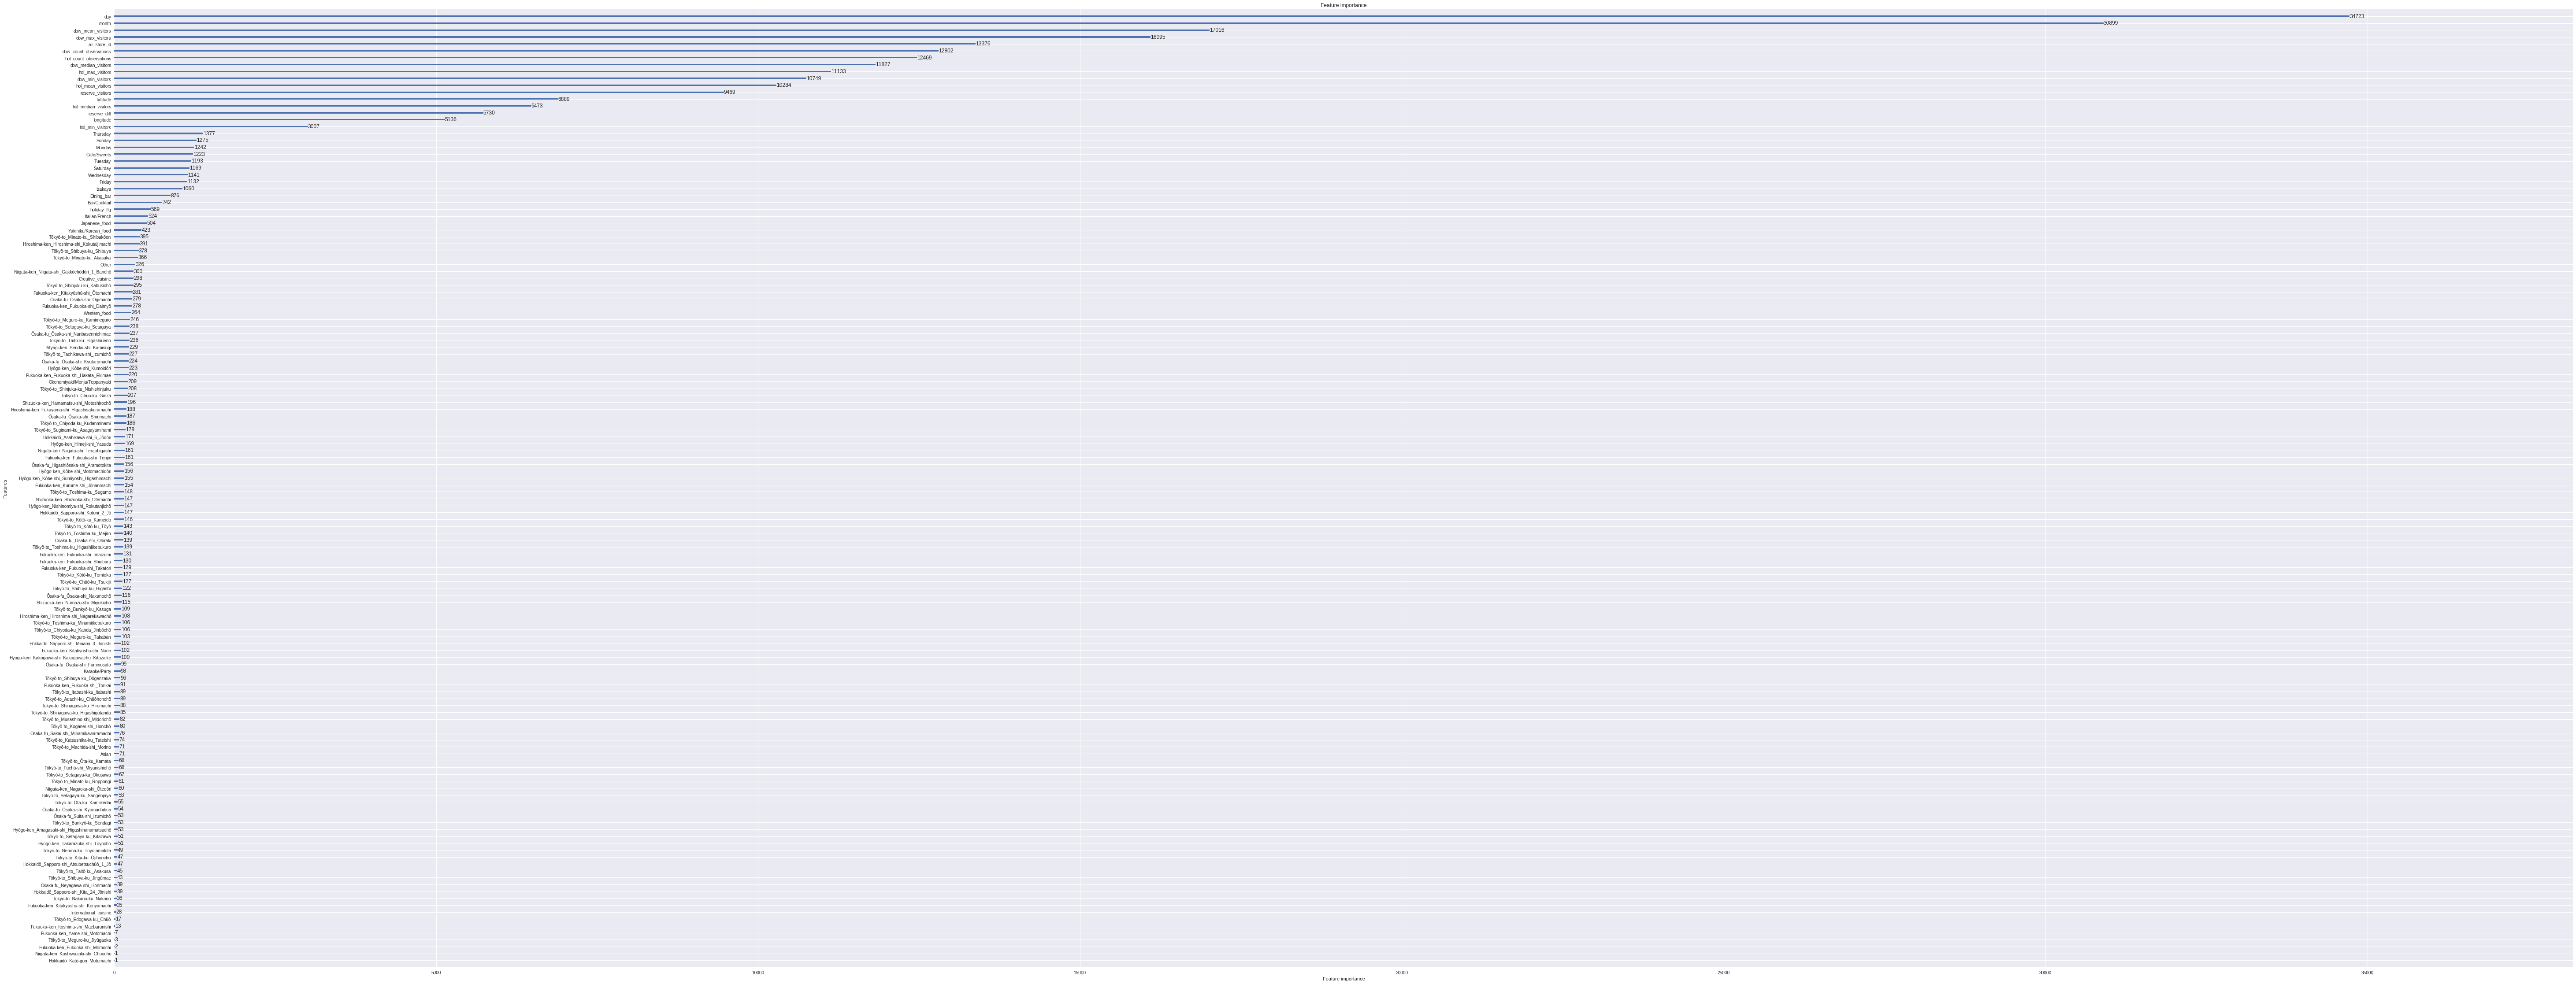

In [83]:
lgb.plot_importance(lgb_model1, figsize= (100, 40))
plt.show()

ほとんどdayとmonthと曜日とストアIDで判定していることがわかります。  
それでvisitorが絞り込めるということのようですね。  
他にも位置情報、予約数も参考にしているようです。  

今回、自分のアイデアとして祝日のmin,max等を追加しましたが、  
それが上手く機能していることがわかりました！